In [204]:
# Prices are in €/MWh while production figures are in kWh it is not handled yet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB


def CalcRevenue(data):
    solutions  = list()
    
    prices = data.iloc[:,:4]
    production = data.iloc[:,4:]
    

    
    for i,row in prices.iterrows():
        
        hourlyRevMod = {}
        for j in range(production.shape[1]-1):
            
            hourlyRev = row['DA_PriceEUR'] * production.iloc[i,j+1]
            
            if production.iloc[i,j+1] > production.iloc[i,0]:
                hourlyRev = hourlyRev - row['BalancingPriceUpEUR'] * (production.iloc[i,j+1]-production.iloc[i,0])
            elif production.iloc[i,0] > production.iloc[i,j+1]:
                hourlyRev = hourlyRev + row['BalancingPriceDownEUR'] * (production.iloc[i,0]-production.iloc[i,j+1])
                
           
            hourlyRevMod[production.columns[j + 1]] = hourlyRev
           
        hourlyRevMod['HourDK'] = row['HourDK']
        solutions.append(hourlyRevMod)    
    
    solutions = pd.DataFrame(solutions)
    return solutions

def Visualise(solutions,data):
    
    prices = data.iloc[:,:4]
    production = data.iloc[:,4:]
    production['HourDK'] = prices['HourDK']
    
    
    
    prices.set_index('HourDK', inplace=True)
    production.set_index('HourDK', inplace=True)
    solutions.set_index('HourDK', inplace=True)
    
    VisProduction(production)
    VisPrices(prices)
    
    
    VisRevenue(solutions)
        
def VisProduction(production):
    num_columns_to_plot = production.shape[1] - 1  # Exclude 'actProd' from the count
    fig, axes = plt.subplots(num_columns_to_plot, 1, figsize=(10, 5 * num_columns_to_plot))

    # Loop through each column after 'actProd'
    for j in range(1, production.shape[1]):  # Start from index 1 to skip 'actProd'
        label = str(production.columns[j])  # Get the column label
        color = (np.random.rand(), np.random.rand(), np.random.rand())
        axes[j-1].plot(production.index, production.iloc[:, j], label=label, marker='o', color=color)  # Plot forecast
        axes[j-1].plot(production.index, production['actProd'], label="Actual Production", marker='o', color='orange')  # Plot actual production
        axes[j-1].set_title(f'{label} vs Actual Production')  # Set title for the subplot
        axes[j-1].set_xlabel('Time')  # Set x-axis label
        axes[j-1].set_ylabel('Power Production')  # Set y-axis label
        axes[j-1].grid()  # Add a grid
        axes[j-1].legend()
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()
    
    plt.title('Production vs. Prediction')
    plt.xlabel('Time')
    plt.ylabel('Energy')
    plt.legend()  # Show the legend
    plt.grid() 
    
def VisPrices(prices):
    
    fig = plt.figure(figsize=(10, 5))
    for j in range(0, prices.shape[1]):
        label = str(prices.columns[j])  # Get the column label
        color = (np.random.rand(), np.random.rand(), np.random.rand())
        plt.plot(prices.index, prices.iloc[:, j], label=label, marker='o', color=color)
    
    plt.title('Price development')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()  
    plt.grid() 
    plt.show()
    
def VisRevenue(solutions):
    
    
    fig, ax = plt.subplots(figsize=(12, 6))

    # Die Positionen für die Balken festlegen
    bar_width = 0.25  # Breite der Balken
    x = np.arange(len(solutions))  # x-Positionen der Balken

    
        
    # Balken für jede Datenreihe zeichnen
    for i, column in enumerate(solutions.columns):
        ax.bar(x + (i - 1) * bar_width, solutions[column], width=bar_width, label=column)

    # Achsen und Titel einstellen
    ax.set_xlabel('Time')
    ax.set_ylabel('Revenue')
    ax.set_title('Revenues based on different ML Models')
    ax.set_xticks(x)
    ax.set_xticklabels(solutions.index.strftime('%Y-%m-%d %H:%M:%S'), rotation=45, ha='right')  # Zeitstempel formatieren
    ax.legend()  # Legende hinzufügen

    # Layout anpassen und Diagramm anzeigen
    plt.tight_layout()
    plt.show()
    
    
# p_t_hat as decision variable
def OptimizationProblemEnergybid(prices_df):
    model = gp.Model()
    solutions  = list()
    capacity = 30000.0
    
    for index, row in prices_df.iterrows():
        
        p_t_hat = model.addVar(name="p_t_hat", lb=0, ub=capacity, vtype=GRB.INTEGER)
        z_down = model.addVar(name="z_down", vtype=GRB.CONTINUOUS, lb=0)
        z_up = model.addVar(name="z_up", vtype=GRB.CONTINUOUS, lb=0)
        
        condition_down = model.addVar(name="condition_down", vtype=GRB.BINARY)
        condition_up = model.addVar(name="condition_up", vtype=GRB.BINARY)
        
        model.addConstr(z_up <= (p_t_hat - row['p_t']) * condition_up)
        model.addConstr(z_up >= (p_t_hat - row['p_t']) * condition_up)
        model.addConstr(z_down <= (row['p_t'] - p_t_hat) * condition_down)
        model.addConstr(z_down >= (row['p_t'] - p_t_hat) * condition_down)
        model.addConstr(condition_up + condition_down == 1)
        
    
        #defining the constraints
        model.addConstr(-p_t_hat <= 0)
        model.addConstr(p_t_hat <= capacity)
        model.addConstr(-z_down <= 0)
        model.addConstr(-z_up <= 0)
        
        model.setObjective((row['DA_PriceEUR']*p_t_hat)+(row['BalancingPriceDownEUR']*z_down-row['BalancingPriceUpEUR']*z_up), GRB.MAXIMIZE)
        
        model.optimize()
    
        if model.status == GRB.OPTIMAL:
            print("Optimal solution found!")
            print(f"Objective Value: {model.ObjVal}")
            values = []
            values.append({ "Day-Ahead-Price": row['DA_PriceEUR'],
                            "BalancingPriceUp":row['BalancingPriceUpEUR'],
                            "BalancingPriceDown":row['BalancingPriceDownEUR'],
                            "p_t":row['p_t'],
                            "Revenue":model.ObjVal})
            for v in model.getVars():
                print(f"{v.varName}: {v.x}")
                values.append({v.varName:v.x})
        
            
            solutions.append({row['HourDK']:values})
                
        elif model.status == GRB.INFEASIBLE:
            print("Model is infeasible.")
            model.computeIIS()
            model.write("infeasible.ilp")  # Write IIS to a file for review
            for c in model.getConstrs():
                if c.IISConstr:
                    print(f"Infeasible constraint: {c.constrName}")
            
            
        elif model.status == GRB.UNBOUNDED:
            print("Model is unbounded.")
        else:
            print("Model status:", model.status)
            
        model.remove(model.getConstrs())
        model.remove(model.getVars())
        
    return solutions
       
#Helping Method to limit the  
def ObservationPeriod(Start_Observation, End_Observation, data):
    Start_Observation = pd.to_datetime(Start_Observation)
    End_Observation = pd.to_datetime(End_Observation)
    condition = (data["HourDK"]>= Start_Observation) & (data["HourDK"]< End_Observation)
    data  = data[condition]
    return data
        

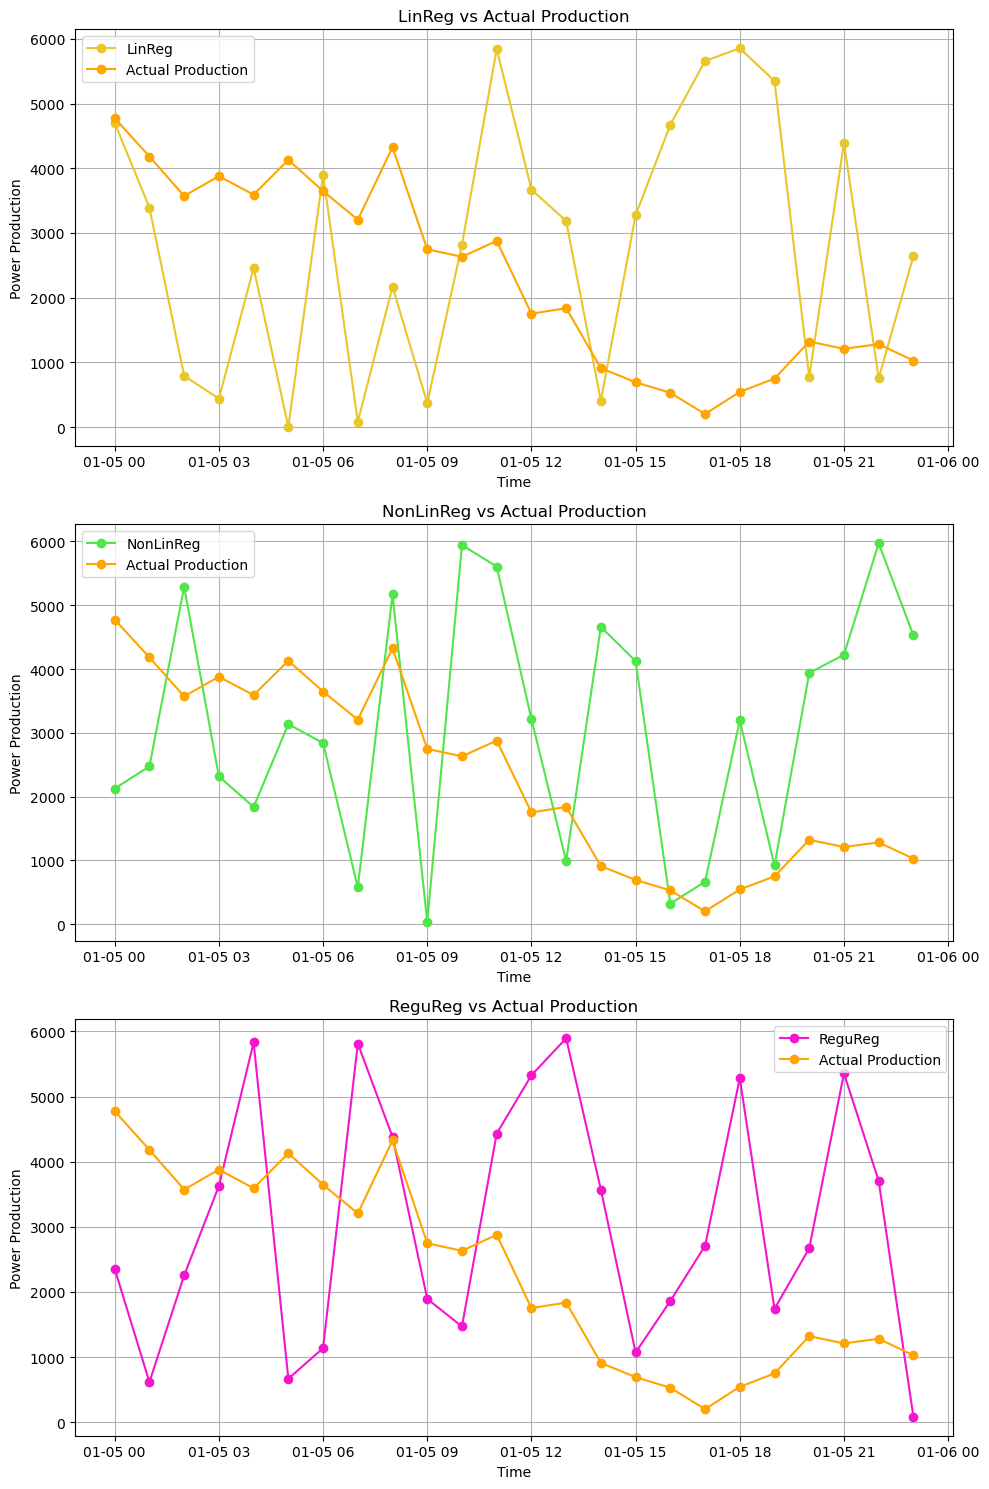

/var/folders/5y/2d5f2m356xd_kxc8krzn20q40000gn/T/ipykernel_11508/3519688525.py:86: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()  # Show the legend


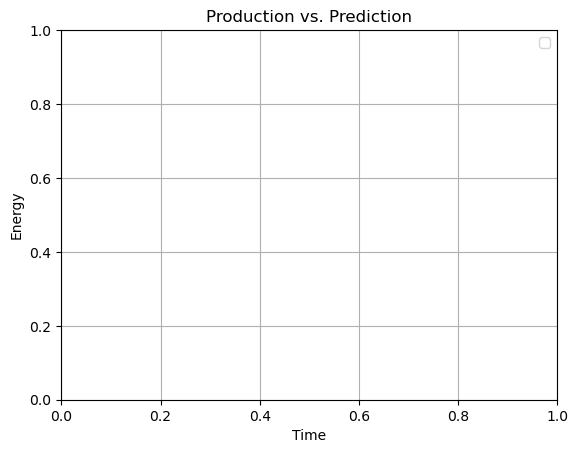

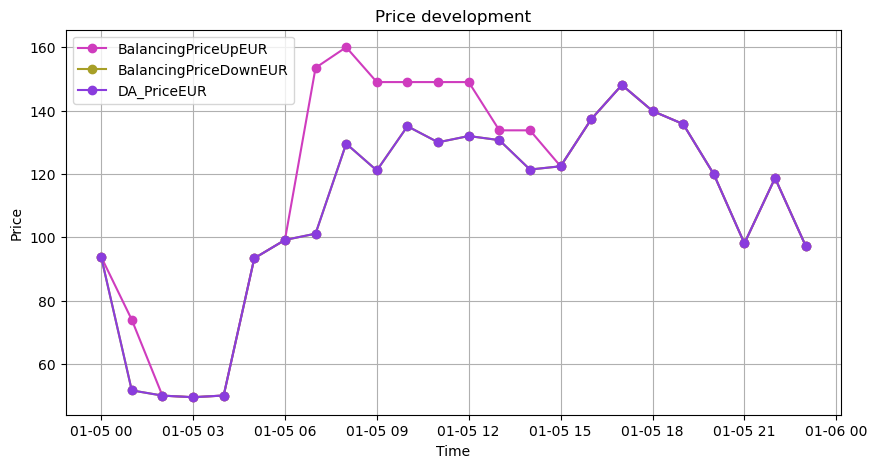

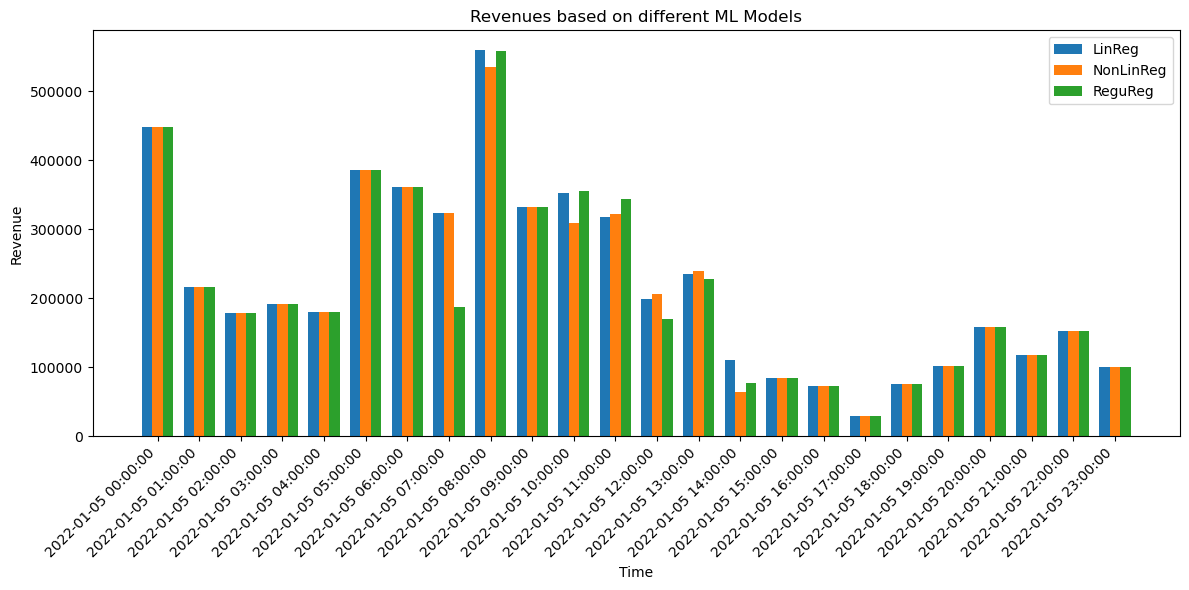

In [205]:
prices_df = pd.read_csv('../Data assignment 1/prices_merged_df_output.csv', delimiter=',')

features_df = pd.read_csv('../Data assignment 1/Feature data.csv', delimiter=',')
features_df['AKI Kalby Active Power'] = -1 * features_df['AKI Kalby Active Power']
data = prices_df.copy()
data['actProd'] = features_df['AKI Kalby Active Power']
data["HourDK"] = pd.to_datetime(data["HourDK"])
#Hier irgendwo muss ich die eigentlichen Zeitreihen hinklatschen

data = ObservationPeriod("2022-01-05 00:00:00", "2022-01-06 00:00:00", data)

#Here is the interface to get the prediction timeseries
p_t1, p_t2, p_t3 = (np.random.uniform(0.0, 6000, size=(24, 1)) for _ in range(3))
p_t1, p_t2, p_t3 = (np.round(arr, 2) for arr in (p_t1, p_t2, p_t3))

data['LinReg'] = p_t1
data['NonLinReg'] = p_t2
data["ReguReg"] = p_t3

data.reset_index(drop=True, inplace=True)

solutions = CalcRevenue(data)
Visualise(solutions, data)



In [58]:
# Hourly Optimmization Problem
data['p_t'] = p_t1
solutions = OptimizationProblemEnergybid(data)
solutions

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[x86] - Darwin 22.6.0 22G830)

CPU model: Intel(R) Core(TM) i5-7360U CPU @ 2.30GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 5 rows, 5 columns and 6 nonzeros
Model fingerprint: 0x8c5874f9
Model has 4 quadratic constraints
Variable types: 2 continuous, 3 integer (2 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 2e+04]
  Objective range  [1e+02, 1e+02]
  Bounds range     [1e+00, 3e+04]
  RHS range        [1e+00, 3e+04]
Presolve removed 4 rows and 1 columns
Presolve time: 0.02s
Presolved: 4 rows, 7 columns, 11 nonzeros
Presolved model has 2 SOS constraint(s)
Variable types: 2 continuous, 5 integer (2 binary)
Found heuristic solution: objective 2662277.1126

Root relaxation: interrupted, 0 iterations, 0.02 seconds (0.00 work units)

Explored 1 nodes (0 simplex iterations) in 0.10 seconds (0.00 work un

/var/folders/5y/2d5f2m356xd_kxc8krzn20q40000gn/T/ipykernel_11508/1635347246.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['p_t'] = p_t


Presolved: 4 rows, 7 columns, 11 nonzeros
Presolved model has 2 SOS constraint(s)
Variable types: 2 continuous, 5 integer (2 binary)
Found heuristic solution: objective 1120951.8569

Root relaxation: interrupted, 0 iterations, 0.00 seconds (0.00 work units)

Explored 1 nodes (0 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 4 (of 4 available processors)

Solution count 1: 1.12095e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.120951856887e+06, best bound 1.120951860300e+06, gap 0.0000%
Optimal solution found!
Objective Value: 1120951.8568874667
p_t_hat: 8493.0
z_down: 0.9899999999761349
z_up: 0.0
condition_down: 1.0
condition_up: -0.0
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[x86] - Darwin 22.6.0 22G830)

CPU model: Intel(R) Core(TM) i5-7360U CPU @ 2.30GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 5 rows, 5 columns and 6 nonzeros
Model fingerprint: 0x88fa8977
Model has 16 

[{Timestamp('2022-01-05 10:00:00'): [{'Day-Ahead-Price': 135.05,
    'BalancingPriceUp': 148.995758,
    'BalancingPriceDown': 135.046509,
    'p_t': 19713.27,
    'Revenue': 2662277.1125574266},
   {'p_t_hat': 19713.0},
   {'z_down': 0.2699999999713327},
   {'z_up': 0.0},
   {'condition_down': 1.0},
   {'condition_up': -0.0}]},
 {Timestamp('2022-01-05 11:00:00'): [{'Day-Ahead-Price': 129.99,
    'BalancingPriceUp': 148.995758,
    'BalancingPriceDown': 129.986282,
    'p_t': 28752.96,
    'Revenue': 3737597.266830729},
   {'p_t_hat': 28752.0},
   {'z_down': 0.9600000000646105},
   {'z_up': 0.0},
   {'condition_down': 1.0},
   {'condition_up': -0.0}]},
 {Timestamp('2022-01-05 12:00:00'): [{'Day-Ahead-Price': 131.97,
    'BalancingPriceUp': 148.995758,
    'BalancingPriceDown': 131.966553,
    'p_t': 8493.99,
    'Revenue': 1120951.8568874667},
   {'p_t_hat': 8493.0},
   {'z_down': 0.9899999999761349},
   {'z_up': 0.0},
   {'condition_down': 1.0},
   {'condition_up': -0.0}]},
 {Timestam